# Image Segmantation for Pothole Detection
(we know this would be very helpful in Romania expecially)

Let's import the dataset:

In [33]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("farzadnekouei/pothole-image-segmentation-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Tudor\.cache\kagglehub\datasets\farzadnekouei\pothole-image-segmentation-dataset\versions\2


In [53]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image

Define basic block of U-Net

In [35]:
class downConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class upConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, in_c // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_c // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_c // 2, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

Define U-Net

In [36]:
class unet_encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = downConv(in_c=3, out_c=64)
        self.block2 = downConv(in_c=64, out_c=128)
        self.block3 = downConv(in_c=128, out_c=256)
        self.block4 = downConv(in_c=256, out_c=512)
        self.block5 = downConv(in_c=512, out_c=1024)
        
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x1 = self.block1(x)
        print(x1.shape)
        x2 = self.block2(self.pool(x1))
        print(x2.shape)
        x3 = self.block3(self.pool(x2))
        print(x3.shape)
        x4 = self.block4(self.pool(x3))
        print(x4.shape)
        x5 = self.block5(self.pool(x4))
        print(x5.shape)

        return [x1, x2, x3, x4, x5]
    
class unet_decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.upconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2,)
        self.upconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2,)
        self.upconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2,)
        self.upconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2,)
        
        self.block1 = upConv(in_c=1024, out_c=512)
        self.block2 = upConv(in_c=512, out_c=256)
        self.block3 = upConv(in_c=256, out_c=128)
        self.block4 = upConv(in_c=128, out_c=64)

    def forward(self, x_set):
        x1_1, x1_2, x1_3, x1_4, x1_5 = x_set
        
        x2_1 = self.upconv1(x1_5)
        x1_4 = x1_4[:, :, :x2_1.shape[2], :x2_1.shape[3]]
        
        x2_1 = torch.cat([x2_1, x1_4], dim=1)
        x2_1 = self.block1(x2_1)
        print(x2_1.shape)
        
        x2_2 = self.upconv2(x2_1)
        x1_3 = x1_3[:, :, :x2_2.shape[2], :x2_2.shape[3]]
        
        x2_2 = torch.cat([x2_2, x1_3], dim=1)
        x2_2 = self.block2(x2_2)
        print(x2_2.shape)

        x2_3 = self.upconv3(x2_2)
        x1_2 = x1_2[:, :, :x2_3.shape[2], :x2_3.shape[3]]
        
        x2_3 = torch.cat([x2_3, x1_2], dim=1)
        x2_3 = self.block3(x2_3)
        print(x2_3.shape)

        x2_4 = self.upconv4(x2_3)
        x1_1 = x1_1[:, :, :x2_4.shape[2], :x2_4.shape[3]]
        
        x2_4 = torch.cat([x2_4, x1_1], dim=1)
        x2_4 = self.block4(x2_4)
        print(x2_4.shape)
        
        return x2_4

In [37]:
class u_net(nn.Module):
    def __init__(self):
        super().__init__()

        self.part1 = unet_encoder()
        self.part2 = unet_decoder()

        self.seg_head = nn.Sequential(
            nn.Conv2d(64, 2, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.part1(x)
        x2 = self.part2(x1)

        x = self.seg_head(x2)

        return x

### Setup a Dataset and a DataLoader

In [73]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset

class YoloSegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, image_size=(640, 640), transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_size = image_size
        self.transform = transform

        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, image_name)
        label_path = os.path.join(self.label_dir, os.path.splitext(image_name)[0] + ".txt")

        # Load image as PIL Image
        image = Image.open(img_path).convert("RGB")

        # Get original width, height for mask scaling
        w, h = image.size

        mask = np.zeros((h, w), dtype=np.uint8)
        if os.path.exists(label_path):
            with open(label_path, "r") as file:
                for line in file:
                    parts = list(map(float, line.strip().split()))
                    cls, coords = parts[0], parts[1:]
                    points = np.array(coords).reshape(-1, 2)
                    points[:, 0] *= w
                    points[:, 1] *= h
                    points = points.astype(np.int32)
                    cv2.fillPoly(mask, [points], color=1)

        # Resize mask with cv2 (to 256x256, same as transform.Resize)
        mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)

        # Apply transforms on PIL image (Resize + ToTensor + Normalize)
        if self.transform:
            image = self.transform(image)

        # Convert mask to tensor
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask

In [74]:
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Converts to [0, 1] range
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize for U-Net
])

train_dataset = YoloSegmentationDataset(
    image_dir=path + '/Pothole_Segmentation_YOLOv8/train/images',
    label_dir=path +'/Pothole_Segmentation_YOLOv8/train/labels',
    transform=transform
)

val_dataset = YoloSegmentationDataset(
    image_dir=path +'/Pothole_Segmentation_YOLOv8/valid/images',
    label_dir=path +'/Pothole_Segmentation_YOLOv8/valid/labels',
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Let's take a look at the image with it's new size

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..1.0].


Text(0.5, 1.0, 'Mask')

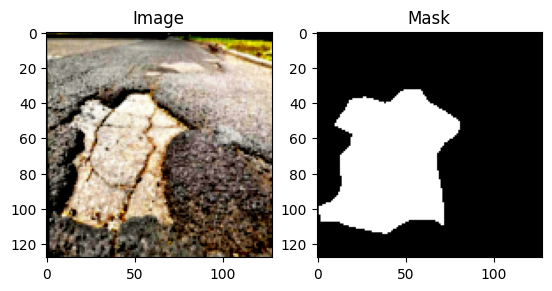

In [75]:
from matplotlib import pyplot as plt  

img, mask = train_dataset[66]
img_disp = img.permute(1, 2, 0).numpy()
mask_disp = mask.squeeze(0).numpy()

plt.subplot(1, 2, 1)
plt.imshow(img_disp)
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask_disp, cmap='gray')
plt.title("Mask")

In [76]:
print(len(train_dataset))
len(val_dataset)

720


60

### Train the model

In [77]:
model = u_net()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

In [78]:
from tqdm import tqdm # cool library

def train(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    
    for images, masks in tqdm(dataloader):

        outputs = model(images)
        
        # If model outputs 2 channels, reduce to 1
        if outputs.shape[1] == 2:
            outputs = outputs[:, 1:2, :, :]  # Take channel 1 (positive class)

        loss = criterion(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


In [79]:
def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            outputs = model(images)
            if outputs.shape[1] == 2:
                outputs = outputs[:, 1:2, :, :]

            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


Ok now let;s train the U net

In [91]:
num_epochs = 20

# for epoch in range(num_epochs):
#     print(f"\nEpoch {epoch+1}/{num_epochs}")
#     train_loss = train(model, train_loader, optimizer, criterion)
#     val_loss = validate(model, val_loader, criterion)

#     print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

### Now let's see some output of the model

torch.Size([1, 64, 128, 128])
torch.Size([1, 128, 64, 64])
torch.Size([1, 256, 32, 32])
torch.Size([1, 512, 16, 16])
torch.Size([1, 1024, 8, 8])
torch.Size([1, 512, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 128, 64, 64])
torch.Size([1, 64, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.94509804].


torch.Size([1, 64, 128, 128])
torch.Size([1, 128, 64, 64])
torch.Size([1, 256, 32, 32])
torch.Size([1, 512, 16, 16])
torch.Size([1, 1024, 8, 8])
torch.Size([1, 512, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.70980394].


torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 128, 128])
torch.Size([1, 128, 64, 64])
torch.Size([1, 256, 32, 32])
torch.Size([1, 512, 16, 16])
torch.Size([1, 1024, 8, 8])
torch.Size([1, 512, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 128, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].


torch.Size([1, 64, 128, 128])


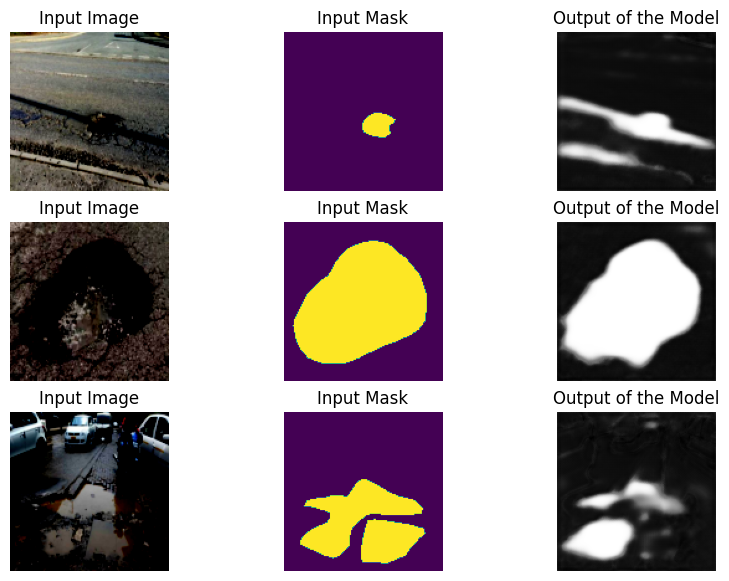

In [97]:
import random
from matplotlib import pyplot as plt

model.eval()
fig = plt.figure(figsize=(10, 7))
n = 3
for i in range(n):
    idx = random.randint(0, len(val_dataset)-1)
    img, mask = val_dataset[idx] # img: [C, H, W]

    input_tensor = img.unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor)
        output = output.squeeze().cpu().numpy()

    # Convert image to [H, W, C] for display 😼
    img_disp = img.permute(1, 2, 0).numpy()
    mask_disp = mask.squeeze(0).numpy()

    plt.subplot(n, 3, 3*i+1)
    plt.imshow(img_disp)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(n, 3, 3*i+2)
    plt.imshow(mask_disp)
    plt.title("Input Mask")
    plt.axis('off')

    plt.subplot(n, 3, 3*i+3)
    if output.ndim == 3:
        output = output[1] if output.shape[0] == 2 else output[0]  # binary seg
    plt.imshow(output, cmap='gray')
    plt.title("Output of the Model")
    plt.axis('off')

plt.show()

### Save the model just in case 

In [92]:
torch.save(model.state_dict(), "unet_weights.pth")

+load if needed

In [93]:
model = u_net()  # Or your model class
model.load_state_dict(torch.load("unet_weights.pth"))
model.eval() 

C:\Users\Tudor\AppData\Local\Temp\ipykernel_7616\1931566518.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_weights.pth"))


u_net(
  (part1): unet_encoder(
    (block1): downConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (block2): downConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (block3): downCo